# Milestone 3 - CS109B Project Group 29
**"Predicting Movie Genres"**<br>
**CS109B (Spring 2017) Final Project Group 29**<br>
Calvin J Chiew, Tim Hagmann, Ji Hua<br>
TF: Taira Miyatake<br>

## Deliverables

- Detailed description and implementation of two different models
- Description of your performance metrics
- Careful performance evaluations for both models
- Visualizations of the metrics for performance evaluation
- Discussion of the differences between the models, their strengths, weaknesses, etc.
- Discussion of the performances you achieved, and how you might be able to improve them in the future

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pickle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

## Overview

In this milestone, we will use movie metadata extracted from TMDb and IMDb to train two "traditional" ML classifiers that can predict movie genres. We will not use movie poster data for now. 

### Performance Metrics

Evaluation of model performance is tricky, due to the multi-label nature of the problem. For example, if a movie's true genre labels are A and B, but our model only predicted label A (or B, but not both) -- was this prediction correct or wrong? And what if the model predicted labels A and B plus an extra C genre? In order to calculate "test accuracy", we would have to make a difficult judgment - whether we valued precision or recall more?

Earlier, we decided to have 20 outcome variables -- 19 binary (1/0) flags, one for each of the 19 genre classifications used by TMDb (namely Adventure, Fantasy, Animation, Drama, Horror, Action, Comedy, History, Western, Thriller, Crime, Documentary, Science Fiction, Mystery, Music, Romance, Family, War and Foreign), and a 20th continuous outcome variable, the number of genre assigned (see Milestone 2 on our choice of outcome 'Y' variables).

After extensive discussion, we felt that in line with our choice of outcome variables, we could evaluate our model's performance on each outcome variable separately. We will therefore end up with 20 performance metrics for our model, which can be visualized and summarized (for example by taking the mean). This will allow us to side-step the problem of defining prediction accuracy as described above.

### Data Preparation

The data was manipulated and cleaned in Milestone 2 in preparation for modelling. In summary, our final dataframe consisted of the following variables:

*Predictors from TMDb*
- Title and plot summary, which have been converted using bag-of-words analysis into a term frequency times inverse document frequency (tf-idf) matrix of 389 vocabulary words (that make up at least 1% of the corpus) 
- Production company, which has been converted into 20 indicator variables, representing the top 20 production companies with the most films
- Release date, which has been transformed into release year and release month
- Runtime (mins)
- Budget (USD)
- Revenue (USD)
- Popularity
- Average user rating (on scale of 1-10)

*Predictors from IMDb*
- Cast (first 5 listed), directors (first 2 listed) and writers (first 2 listed), which have been converted into 150, 75 and 75 indicator variables respectively, representing the top 150 cast and top 75 directors and writers with the most films
- US MPAA picture rating (eg. PG-13, R-21 etc.)

*Outcome Variables*
- TMDb genres, which have been dummy-coded into 19 indicator variables, one for each genre category
- Number of TMDb genre tags

---

## Prepare Train & Test Sets

In [2]:
# read in dataframe
data = pd.read_csv("data/merged2.csv")
data = data.drop(['Unnamed: 0', 'tmdb_id', 'imdb_id'], axis=1)
data.head()

C:\Users\Calvin\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (1,2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,budget,revenue,runtime,popularity,user_rating,release_year,release_month,USA_rating,Warner Bros,Metro-Goldwyn-Mayer MGM,...,Crime,Documentary,Science Fiction,Mystery,Music,Romance,Family,War,Foreign,num_genres
0,0.0,0.0,69,0.623849,6.8,1988.0,10.0,Missing,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,0.0,0.0,76,0.288572,6.8,1986.0,10.0,Missing,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,4000000.0,4300000.0,98,1.76899,6.4,1995.0,12.0,R,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,12136938.0,110,0.676269,6.6,1993.0,10.0,R,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,42000.0,0.0,80,0.125477,5.2,2006.0,1.0,Missing,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [3]:
# convert data types
data['runtime'] = data['runtime'].apply(pd.to_numeric, errors='coerce')
data['popularity'] = data['popularity'].apply(pd.to_numeric, errors='coerce')

# replace nan
data['runtime'].fillna(0, inplace=True)
data['popularity'].fillna(0, inplace=True)

In [4]:
data.shape

(80086, 437)

In [5]:
# separate x and y
y = data.ix[:, 417:437]
x = data.ix[:, 0:417]

In [6]:
y.head()

,Adventure,Fantasy,Animation,Drama,Horror,Action,Comedy,History,Western,Thriller,Crime,Documentary,Science Fiction,Mystery,Music,Romance,Family,War,Foreign,num_genres
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
y.shape

(80086, 20)

In [8]:
x.head()

,budget,revenue,runtime,popularity,user_rating,release_year,release_month,USA_rating,Warner Bros,Metro-Goldwyn-Mayer MGM,...,word_work,word_working,word_works,word_world,word_writer,word_written,word_year,word_years,word_york,word_young
0,0.0,0.0,69.0,0.623849,6.8,1988.0,10.0,Missing,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,76.0,0.288572,6.8,1986.0,10.0,Missing,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2,4000000.0,4300000.0,98.0,1.768986,6.4,1995.0,12.0,R,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.0,12136938.0,110.0,0.676269,6.6,1993.0,10.0,R,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
4,42000.0,0.0,80.0,0.125477,5.2,2006.0,1.0,Missing,0.0,0.0,...,0.0,0.0,0.0,0.119018,0.0,0.180166,0.0,0.0,0.165786,0.0


In [9]:
x.shape

(80086, 417)

In [10]:
# get dummy variables for release_year, release_month, USA_rating
x = pd.get_dummies(x, columns=['release_year', 'release_month', 'USA_rating'])

In [12]:
# create training and testing sets (66% train, 33% test)
np.random.seed(123)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [13]:
x_train.shape

(53657, 581)

In [14]:
x_test.shape

(26429, 581)

In [15]:
# select 19 genre classes
y_train19 = y_train.ix[:, 0:19]
y_test19 = y_test.ix[:, 0:19]

---

## Model 0: Baseline Model

Here, we create a baseline model, which flags a genre randomly at a probability of around 10%, which is the overall proportion of binary flag '1' across all 19 genres classes. This serves as a benchmark for our two models. 

In [16]:
def random_classifier(df_y):
    prop = df_y.sum() / df_y.shape[0]
    pred = np.random.binomial(1, np.mean(prop), df_y.shape)
    return pred

In [17]:
# naive model
np.random.seed(123)
pred_baseline = random_classifier(y_test19)

# show test accuracies for each class
acc_baseline = np.mean(pred_baseline == y_test19)
acc_baseline

Adventure          0.845435
Fantasy            0.862575
Animation          0.853456
Drama              0.568580
Horror             0.815808
Action             0.780733
Comedy             0.659654
History            0.878353
Western            0.874683
Thriller           0.783344
Crime              0.831814
Documentary        0.824965
Science Fiction    0.853646
Mystery            0.863597
Music              0.864354
Romance            0.785312
Family             0.844073
War                0.878656
Foreign            0.841462
dtype: float64

In [18]:
# overall accuracy
print "Overall baseline accuracy", round(acc_baseline.sum() / 19 * 100, 2), "%\n"

Overall baseline accuracy 81.63 %



---

## Model 1: Random Forest

Given this multi-class, multi-label problem, we will employ one-vs-rest (OvR) strategy, which consists of fitting one classifier per genre. For each classifier, the class is fitted against all the other classes. 

To address the imbalanced nature of this dataset (as discussed in Milestone 2), we will use balanced class weights.

In [19]:
# fit random forest
rf = RandomForestClassifier(class_weight="balanced").fit(x_train, y_train19)

In [20]:
# predict on test set
pred_rf = rf.predict(x_test)

# show test accuracies for each class
acc_rf = np.mean(pred_rf == y_test19)
acc_rf

Adventure          0.940142
Fantasy            0.960611
Animation          0.956412
Drama              0.701464
Horror             0.906050
Action             0.870067
Comedy             0.742783
History            0.977714
Western            0.976806
Thriller           0.869764
Crime              0.925574
Documentary        0.931477
Science Fiction    0.948882
Mystery            0.960271
Music              0.960914
Romance            0.884142
Family             0.942752
War                0.979076
Foreign            0.937833
dtype: float64

In [21]:
# overall accuracy
print "Overall random forest accuracy", round(acc_rf.sum() / 19 * 100, 2), "%\n"

Overall random forest accuracy 91.44 %



In [22]:
# save random forest to disk
path = 'models/rf.sav'
pickle.dump(rf, open(path, 'wb'))

---

## Model 2: *k*-Nearest Neighbors

We now model the same training set using k-Nearest Neighbors, choosing an arbitrary value of k=5.

In [23]:
# fit knn where k=5
knn = KNeighborsClassifier(n_neighbors=5).fit(x_train, y_train19)

In [24]:
# predict on test set
pred_knn = knn.predict(x_test)

# show test accuracies for each class
acc_knn = np.mean(pred_knn == y_test19)
acc_knn

Adventure          0.933331
Fantasy            0.955012
Animation          0.959628
Drama              0.631465
Horror             0.887169
Action             0.842181
Comedy             0.683681
History            0.974800
Western            0.972455
Thriller           0.843089
Crime              0.912558
Documentary        0.909569
Science Fiction    0.941920
Mystery            0.954860
Music              0.955163
Romance            0.854100
Family             0.931401
War                0.976352
Foreign            0.924099
dtype: float64

In [25]:
# overall accuracy
print "Overall k-nearest neighbors accuracy", round(acc_knn.sum() / 19 * 100, 2), "%\n"

Overall k-nearest neighbors accuracy 89.7 %



In [22]:
# save knn to disk
path = 'models/knn.sav'
pickle.dump(knn, open(path, 'wb'))

---

SVM was considered as an alternative model but not used in view of computation time.

Since sklearn's support vector classifier does not have inherent multi-label support, we wrap it with the OneVsRestClassifer function. In view of computation time, we used a linear kernel here (rather than RBF).

In [ ]:
# fit linear svm
svm = OneVsRestClassifier(SVC(kernel='linear', class_weight='balanced')).fit(x_train, y_train19)

---

## Logistic Regression Model for Number of Genre Labels

In addition to the 19 genre outcomes, we would like another model that can predict the number of genres to be assigned to each movie. Using this predicted number, we can then assign genres to each test movie when we also have the predicted probabilities of every genre (obtained from above models). Here, we use logistic regression to predict the number of genre labels, by treating it as a categorical variable (with multiple classes).

In [81]:
# select number of genre labels as outcome
y_train20 = y_train.ix[:, 19]
y_test20 = y_test.ix[:, 19]

In [92]:
# fit logistic regression
log = LogisticRegression(class_weight='balanced').fit(x_train, y_train20)

In [95]:
# predict on test set
pred_log = log.predict(x_test)

# calculate accuracy
acc_log = np.mean(pred_log == y_test20)

print "Overall accuracy:", round(acc_log * 100, 2), "%\n"
print "Confusion matrix:"
pd.crosstab(pred_log, y_test20, rownames=['True'], colnames=['Predicted'], margins=True)

Overall accuracy: 32.85 %

Confusion matrix:


Predicted,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,All
True,,,,,,,,,
2.0,47,11206,8416,4040,1132,229,35,7,25112
3.0,0,194,299,262,166,56,14,0,991
4.0,0,2,2,2,0,0,0,0,6
5.0,0,1,0,0,0,1,0,0,2
6.0,0,42,46,73,53,22,4,0,240
7.0,0,2,9,32,9,9,1,0,62
8.0,0,4,0,3,0,0,0,0,7
10.0,0,3,4,1,1,0,0,0,9
All,47,11454,8776,4413,1361,317,54,7,26429


We note that the accuracy of this model which predicts the number of genre labels is fairly low. This is partly due to a large number of classes.

However, we know from earlier data exploration that the majority of movies are tagged with 3 or less genres (see Milestone 2). If we believe that it is more important to have few but highly accurate genre tags, as opposed to more but less accurate tags, then in the final combined prediction, we should simply assign each movie 1 or 2 genres with the highest predicted probabilities (eg. from the random forest), rather than also trying to predict the number of genre labels.

In [96]:
# save log to disk
path = 'models/log.sav'
pickle.dump(log, open(path, 'wb'))

---

## Model Comparison

Here, we visualize the performance of the two models across the 19 genres.

In [26]:
# convert accuracies to dataframe 
acc1 = pd.DataFrame(acc_baseline, columns=['Baseline'])
acc2 = pd.DataFrame(acc_knn, columns=['KNN'])
acc3 = pd.DataFrame(acc_rf, columns=['Random Forest'])

# merge into one dataframe
acc = pd.concat([acc1, acc2, acc3], axis=1)

In [27]:
# save to csv
acc.to_csv('model_acc.csv')

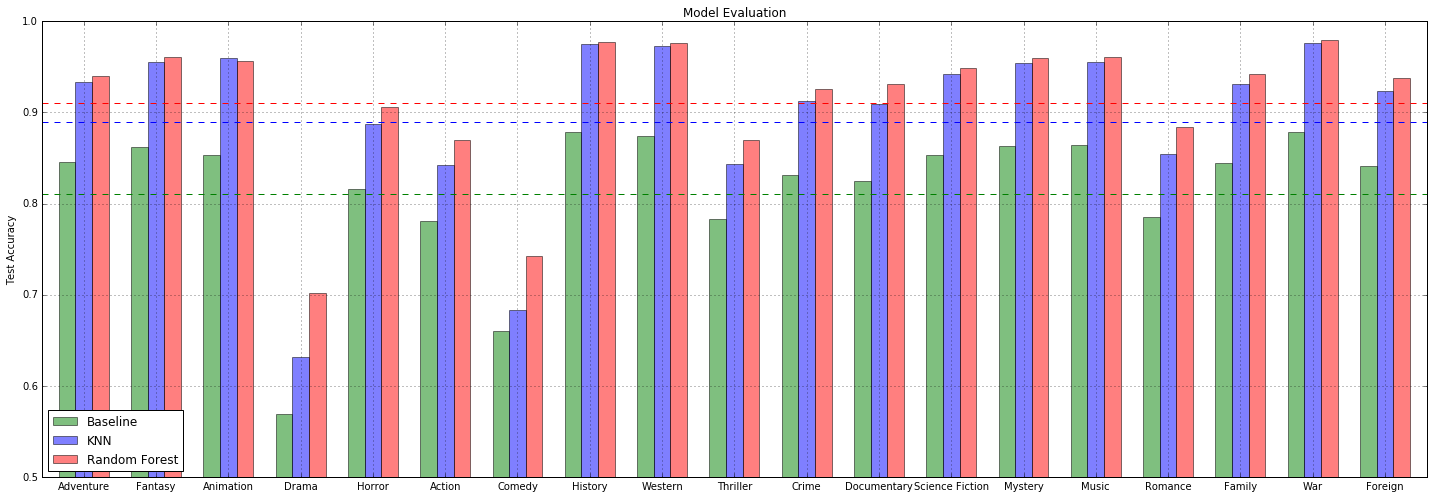

In [73]:
# create plot
fig, ax = plt.subplots(figsize=(20,7))
pos = list(range(len(acc['Baseline'])))
width = 0.23

# baseline bars
plt.bar(pos, acc['Baseline'], width, alpha=0.5, color='green', label='Baseline')

# knn bars
plt.bar([p + width for p in pos], acc['KNN'], width, alpha=0.5, color='b', label='KNN')

# random forest bars
plt.bar([p + width*2 for p in pos], acc['Random Forest'], width, alpha=0.5, color='r', label='Random Forest')

# labels
ax.set_ylabel('Genre')
ax.set_ylabel('Test Accuracy')
ax.set_title('Model Evaluation')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(acc.index)

# limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim(0.5, 1.0)

# overall accuracies
plt.axhline(y=0.91, color='r', linestyle='dashed')
plt.axhline(y=0.89, color='b', linestyle='dashed')
plt.axhline(y=0.81, color='g', linestyle='dashed')

plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()

In general, both models achieved pretty similar test accuracy results across all classes, with the random forest model (overall accuracy 91%) slightly edging out the kNN model (overall accuracy 89%). Both models performed better than the baseline model (overall accuracy 81%), which was intentionally designed as a very high benchmark. The hardest genres to predict correctly were drama and comedy (test accuracies below 80%). Both models are able to deal well with non-linear decision boundaries. 

---

## Discussion

We believe these are the strengths of our models:
- Large sample size (~80,000 observations total, ~54,000 in training set and ~26,000 in testing set)
- Wide variety of promising predictors which were gathered from both IMDb and TMDb
- Use of methods that were appropriate for the multi-label problem
- Accounted for class imbalance

Our models had several weaknesses which we could have improved on as follows:
- The parameters of our models were not optimized. Given more time, we would conduct parameter tuning of our models to improve their performance.
- We note the large number of predictor (X) variables in our dataset (almost 900 including dummy variables). We could have applied PCA prior to modelling for dimensionality reduction. We could have also coded 'release year' into decades or five-year intervals instead of dummy-coding it directly to reduce the number of predictors somewhat.
- We could have incorporated poster data into our models. However, conversion of the w500 posters into pixel arrays resulted in a large matrix with 1,125,000 features (see Milestone 2). Given the large size of this matrix, it would not have been possible to load and manipulate it on our local machines.
- We could have scaled (normalized) our data prior to modelling. (However, random forest is scale invariant.)
- We could have explored other ML models such as SVM, LDA/QDA, boosting etc.
- We could have considered other performance metrics such as precision/recall, F1 score etc.

---

## Next Steps

Moving forward, we will employ deep learning for the genre prediction task and train a network using movie poster images on AWS. We can compare its performance to the above traditional models trained on movie metadata and even combine both together. 